In [1]:
# code to replicate arXiv:1412.2043v2
import numpy as np; import numpy
from mpmath import mp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import astropy.units as u
import astropy.constants as c
from collections import namedtuple
# all units should be natural units and in GeV unless otherwise noted

In [2]:
# constants
M_pl = 2.435e18 # reduced Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
m_pl = 1.220910e19 # Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
g_star = 427/4 # during reheating from paper
sigma_eff = 1e-31 # [GeV^-2] from paper heavy neutrino exchange 
N_f = 3 # [1] fermion generations
# TODO: renormalization group running?
g_2 = 0.652 # [1] from wikipedia (https://en.wikipedia.org/wiki/Mathematical_formulation_of_the_Standard_Model#Free_parameters)
alpha = g_2**2 / (4 * np.pi) # eq. from paper
theta0 = 1 # use value from paper for now (maybe vary it later?)
c_shaleron = 28/79 # from paper
g_star_0 = 43/11 # from paper
eta_B_observed = 6e-10 # from paper
L_to_B_final_factor = c_shaleron * g_star_0 / g_star # formula from paper (*)
t_end_inf = (1e-32 * u.second / c.hbar).to("1/GeV").value # [1/eV] number from wikipedia, is that what is used? https://en.wikipedia.org/wiki/Inflationary_epoch 
print("t_end_inf =", t_end_inf)

t_end_inf = 1.519267447878626e-08


In [3]:
# helper functions
def eta_L_a_to_eta_B_0(eta_L_a): 
    return L_to_B_final_factor * eta_L_a # formula from paper (*)

def calc_Gamma_a(m_a, f_a):
    return alpha**2 / (64 * np.pi**3) * m_a**3 / f_a**2 # from paper

def calc_a0(f_a):
    return theta0 * f_a # from paper, standard definition

def calc_temperature(rho_R):
    # in the paper its
    # (np.pi**2 / 3 * g_star * rho_R)**(1/4)
    # but I think it should be 
    # rho_rad = pi^2 / 30 * g_star * T^4
    return (rho_R / g_star * 30 / np.pi**2)**(1/4)

def calc_radiation_energy_density(T):
    return np.pi**2 / 30 * g_star * T**4

def calc_hubble_parameter(rho_total):
    return np.sqrt(rho_total) / (np.sqrt(3) * M_pl) # Friedmann

def calc_rho_R(rho_phi, rho_tot):
    return rho_tot - rho_phi # neglegt axion 

def calc_energy_density_from_hubble(H):
    return 3 * M_pl**2 * H**2 # Friedmann eq.

def calc_lepton_asym_in_eqi(T, mu_eff):
    return 4 / np.pi**2 * mu_eff * T**2 # boltzmann thermodynamics

zeta3 = 1.20206
g_photon = 2
def calc_photon_number_density(T):
    return zeta3 / np.pi**2 * g_photon * T**3 # K&T (3.52)

def calc_asym_parameter(T, n_L):
    n_gamma = calc_photon_number_density(T)
    return n_L / n_gamma # definition

def calc_Gamma_L(T):
    n_l_eq = 2 / np.pi**2 * T**3
    return 4 * n_l_eq * sigma_eff # is this term only active in a certain range?

In [15]:
# analyical results for reheating
def calc_rho_phi_analytical(t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    return rho_phi_0 * (R / R_osc)**-3 * np.exp(- Gamma_phi * (t - t0)) # K&T (8.30)

def calc_rho_R_analytical(t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    start = (6 / np.pi)**0.5 / 10 * m_pl * Gamma_phi * rho_phi_0**0.5 * (R / R_osc)**(-3/2) * (1 - (R / R_osc)**(-5/2)) # K&T (8.32)
    t_RH = 1 / Gamma_phi
    i_RH = np.where(t >= t_RH)[0][0]
    rho_R_RH = calc_rho_phi_analytical(t0, t, R_osc, R, rho_phi_0, Gamma_phi)
    R_RH = R[i_RH]
    rad_dom = rho_R_RH * (R / R_RH)**(-4)
    return start # np.where(t < t_RH, start, rad_dom)

In [16]:
def calc_H_inf_max(f_a):
    return 6e11 * (f_a / 1e15) # paper

def constraints(m_a, f_a, Gamma_phi, H_inf):
    # all from paper:
    assert Gamma_phi <= H_inf # no inflaton decay before the end of inflation
    assert H_inf <= calc_H_inf_max(f_a) # isocurvature
    assert m_a <= H_inf # axion not part of inflation
    assert m_a >= 8e4*(f_a / 1e15)**(2/3) # reheating from axion decay large enough  

In [17]:
SimulationResult = namedtuple("SimulationResult", 
    ["t", "rho_phi", "rho_R", "rho_tot", "T", "H", "R", "theta", "theta_dot", "n_L"])

In [18]:
# numerical implementation of the complete model
theta_index = 3
theta_diff_index = theta_index + 1
n_L_index = theta_diff_index + 1
R_osc = 1.0

def rhs(log_t, y, Gamma_phi, m_a, Gamma_a):
    # coordinate transformation
    t = np.exp(log_t)
    rho_phi, rho_tot, R = np.exp(y[:theta_index])
    theta = y[theta_index]
    d_theta_d_log_t = y[theta_diff_index]
    theta_dot = d_theta_d_log_t / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    n_L = y[n_L_index]
    
    # Friedmann
    H = calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    
    # reheating energy equations rewritten in rho_phi and roh_tot instead of rho_phi and phi_R and in loglog space
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    
    # axion eom (Klein Gordon) in theta and log t
    theta_dot2         = - (3 * H + Gamma_a) * theta_dot - m_a**2 * theta
    d2_theta_d_log_t_2 = d_theta_d_log_t + t**2 * theta_dot2
    
    # Boltzmann eq. for lepton asymmetry
    mu_eff = theta_dot
    n_L_eq = calc_lepton_asym_in_eqi(T, mu_eff)
    Gamma_L = calc_Gamma_L(T)
    d_n_L_d_log_t = t * (- 3 * H * n_L - Gamma_L * (n_L - n_L_eq))
    
    # final result
    return (
        d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, 
        d_log_R_d_log_t, 
        d_theta_d_log_t, d2_theta_d_log_t_2,
        d_n_L_d_log_t,
    )

def simulate(m_a, f_a, Gamma_phi, H_inf, theta0=1.0, start=t_end_inf, end=1e-5, samples=500, solver="RK45"):
    constraints(m_a, f_a, Gamma_phi, H_inf) # make sure constrains are satisfied 
    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    initial_conditions = np.array([np.log(rho_phi_0), np.log(rho_phi_0), np.log(R_osc), theta0, 0.0, 0.0])
    interval = (start, end) 
    sol = solve_ivp(rhs, np.log(interval), initial_conditions, 
                    args=(Gamma_phi, m_a, calc_Gamma_a(m_a, f_a)), 
                    t_eval=np.log(np.geomspace(*interval, samples))[:-1], 
                    method=solver,
                   )
    t = np.exp(sol.t)
    rho_phi, rho_tot, R = np.exp(sol.y[:theta_index])
    theta, n_L = sol.y[theta_index], sol.y[n_L_index]
    theta_dot = sol.y[theta_diff_index] / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    H = calc_hubble_parameter(rho_tot)
    return SimulationResult(t=t, rho_R=rho_R, rho_phi=rho_phi, rho_tot=rho_tot, H=H, R=R, T=T, theta=theta, theta_dot=theta_dot, n_L=n_L)

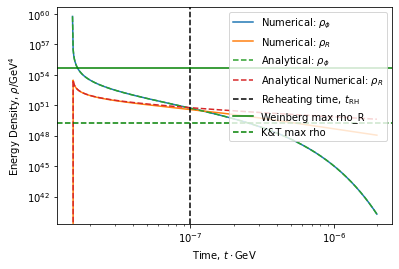

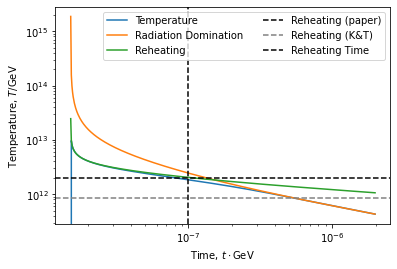

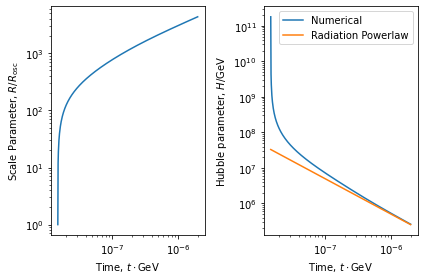

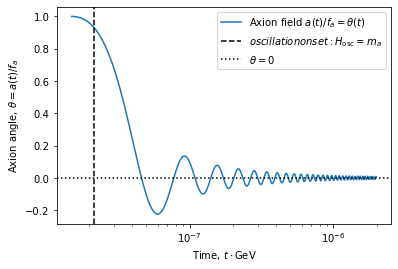

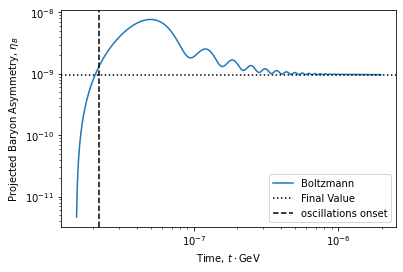

final asymmetry: 9.662406753364662e-10


In [41]:
# test parameters
m_a = 1e8 # [GeV]
f_a = 3e14 # [GeV] from fig. 1
Gamma_phi = 1e7 # [GeV]
H_inf = calc_H_inf_max(f_a)
t, rho_phi, rho_R, rho_tot, T, H, R, theta, theta_dot, n_L = simulate(m_a, f_a, Gamma_phi, H_inf, end=2e-6)

# plot results
rho_phi_0 = calc_energy_density_from_hubble(H_inf)
time_label = r"Time, $t \cdot \mathrm{GeV}$"
T_RH = 2e13 * np.sqrt(Gamma_phi / 1e9) # paper
T_max = 5e13 * (Gamma_phi / 1e9)**(1/4) * (H_inf / 1e11)**(1/2) # paper
T_RH_KT = 0.55 * g_star**(-1/4) * (M_pl * Gamma_phi)**0.5 # K&T
T_max_KT = 0.8 * g_star**0.5 * rho_phi_0**0.5 * (Gamma_phi * m_pl)**(1/4) # K&T
t_RH = 1 / Gamma_phi

# energy densities
plt.figure()
plt.loglog(t, rho_phi, label=r"Numerical: $\rho_\phi$")
plt.loglog(t, rho_R, label=r"Numerical: $\rho_R$")
#plt.loglog(t, rho_tot, label=r"Numerical: $\rho_\mathrm{tot}$")
plt.loglog(t, calc_rho_phi_analytical(t_end_inf, t, R_osc, R, rho_phi_0, Gamma_phi), 
           ls="--", label=r"Analytical: $\rho_\phi$")
plt.loglog(t, calc_rho_R_analytical(t_end_inf, t, R_osc, R, rho_phi_0, Gamma_phi), 
           ls="--", label=r"Analytical Numerical: $\rho_R$")
plt.axvline(t_RH, label=r"Reheating time, $t_\mathrm{RH}$", color="black", ls="--")
plt.axhline(0.139 * Gamma_phi / H_inf * rho_phi_0, color="green", ls="-", label="Weinberg max rho_R")
plt.axhline(calc_radiation_energy_density(T_RH_KT), color="green", ls="--", label="K&T max rho")
plt.legend()
plt.xlabel(time_label)
plt.ylabel(r"Energy Density, $\rho / \mathrm{GeV}^4$")
plt.show()

# temperature
plt.figure()
plt.loglog(t, T, label="Temperature", color="tab:blue") # from simulation
# analytic results for different epochs
plt.loglog(t, T[-1] * (R/R[-1])**-1, color="tab:blue", label="Radiation Domination")
max_T_idx = np.argmax(T)
plt.loglog(t, T[max_T_idx]*(R / R[max_T_idx])**(-3/8), ls="--", label="Reheating")
# reheating and maximal temperature
plt.axhline(T_RH, label="Reheating (paper)", ls="--", color="black")
# plt.axhline(T_max, label="Maximal (paper)", ls=":", color="black")
plt.axhline(T_RH_KT, label="Reheating (K&T)", ls="--", color="grey")
# plt.axhline(T_max_KT, label="Maximal Temperature (K&T)", ls=":", color="grey")
plt.axvline(t_RH, label="Reheating Time", ls="--", color="black")
# labels
plt.legend(ncol=2)
plt.xlabel(time_label)
plt.ylabel(r"Temperature, $T / \mathrm{GeV}$")
#plt.ylim(plt.ylim()[0], np.max(T) * 2)
plt.show()

# scale factor
plt.figure()
plt.subplot(1,2,1)
plt.loglog(t, R / R_osc)
plt.xlabel(time_label)
plt.ylabel(r"Scale Parameter, $R / R_\mathrm{osc}$")
# Hubble parameter
plt.subplot(1,2,2)
plt.loglog(t, H, label="Numerical")
plt.loglog(t, 1 / (2*t), label="Radiation $H = 1/2t$")
plt.xlabel(time_label)
plt.ylabel(r"Hubble parameter, $H / \mathrm{GeV}$")
plt.legend()
plt.tight_layout()
plt.show()

# axion field 
plt.figure()
plt.semilogx(t, theta, label=r"Axion field $a(t) / f_a = \theta(t)$")
plt.xlabel(time_label)
plt.ylabel(r"Axion angle, $\theta = a(t) / f_a$")
t_osc = t[np.where(m_a > H)[0][0]]
plt.axvline(t_osc, label=r"Oscillation Onset: $H_\mathrm{osc} = m_a$", color="black", ls="--")
plt.axhline(0, label=r"$\theta = 0$", color="black", ls=":")
plt.legend()
plt.show()

# asymmetry parameter
plt.figure()
# the minus sign comes from the fact that we are actually computing B - L
eta_B = -eta_L_a_to_eta_B_0(calc_asym_parameter(T[1:], n_L[1:]))
plt.plot(t[1:], eta_B, label="Boltzmann")
plt.axhline(eta_B[-1], color="black", ls=":", label="Final Value")
plt.axvline(t_osc, color="black", ls="--", label="Oscillation Onset")
#plt.plot(t, eta_L_a_to_eta_B_0(calc_asym_parameter(T, calc_lepton_asym_in_eqi(T, theta_dot))),v label="Equilibrium")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(time_label)
plt.ylabel(r"Projected Baryon Asymmetry, $\eta_B$")
plt.legend(loc="lower right")
plt.show()

print("final asymmetry:", eta_B[-1])

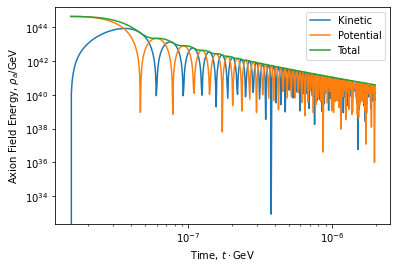

<ipython-input-37-a3ef0c420408>:15: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(t, theta_dot / T)


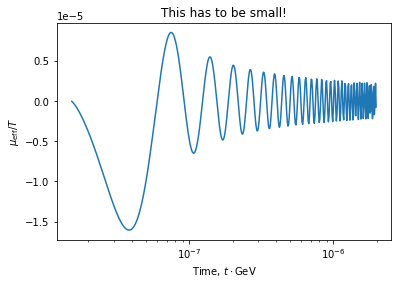

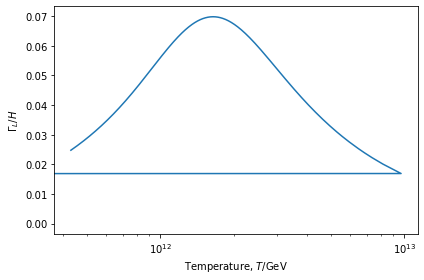

In [37]:
###################### debugging plots ######################
# axion field energies
rho_kin = 0.5 * theta_dot**2 * f_a**2
rho_pot = 0.5 * m_a**2 * f_a**2 * theta**2 
rho_a = rho_kin + rho_pot
plt.loglog(t, rho_kin, label="Kinetic")
plt.loglog(t, rho_pot, label="Potential")
plt.loglog(t, rho_a, label="Total")
plt.xlabel(time_label)
plt.ylabel(r"Axion Field Energy, $\rho_a / \mathrm{GeV}$")
plt.legend(loc=1)
plt.show()
# chemical potentail vs temperature
plt.figure()
plt.semilogx(t, theta_dot / T)
plt.title("This has to be small!")
plt.xlabel(time_label)
plt.ylabel(r"$\mu_\mathrm{eff} / T$")
plt.show()
# Equilibrium tracking
plt.figure()
plt.semilogx(T, calc_Gamma_L(T) / H)
plt.xlabel(r"Temperature, $T / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_L / H$")
plt.tight_layout()
plt.show()

In [36]:
######### compare solutions for reheating equations using different solvers ##########
def reheating_mp_solution(H_inf, Gamma_phi, ts): # use function to avoid name conflicts 
    mp.dps = 30
    g_star = mp.mpf("427/4") # during reheating from paper
    M_pl = mp.mpf("2.435e18") 
    t_end_inf = mp.mpf("1.519267447878626e-08")
    H_inf = mp.mpf(H_inf)
    Gamma_phi = mp.mpf(Gamma_phi) # [GeV]
    rho_tot_inf = 3 * M_pl**2 * H_inf**2

    def rhs(log_t, log_y):
        t = mp.exp(log_t)
        log_rho_tot, log_rho_phi = log_y
        rho_tot, rho_phi = mp.exp(log_rho_tot), mp.exp(log_rho_phi)
        rho_R = rho_tot - rho_phi
        H = mp.sqrt(rho_tot) / (mp.sqrt(3) * M_pl)
        d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
        d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
        return d_log_rho_tot_d_log_t, d_log_rho_phi_d_log_t

    mp_sol = mp.odefun(rhs, mp.log(t_end_inf), [mp.log(rho_tot_inf), mp.log(rho_tot_inf)])
    log_t_range = [mp.log(mp.mpf(t)) for t in ts]
    history = [mp_sol(log_t) for log_t in log_t_range]
    rho_tot = numpy.array([float(mp.exp(h[0])) for h in history])
    rho_phi = numpy.array([float(mp.exp(h[1])) for h in history])
    rho_R = rho_tot - rho_phi
    t = numpy.array([float(mp.exp(log_t)) for log_t in log_t_range])
    return rho_phi, rho_R
rho_phi_mp, rho_R_mp = reheating_mp_solution(H_inf, Gamma_phi, t)

def reheating_implicit_solution(ts):
    def rhs(log_t, log_y):
        t = np.exp(log_t)
        rho_tot, rho_phi = np.exp(log_y)
        rho_R = rho_tot - rho_phi
        H = np.sqrt(rho_tot) / (np.sqrt(3) * M_pl)
        d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
        d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
        return d_log_rho_tot_d_log_t, d_log_rho_phi_d_log_t
    rho_tot_inf = calc_energy_density_from_hubble(H_inf)
    initial_conditions = [np.log(rho_tot_inf), np.log(rho_tot_inf)]
    sol = solve_ivp(rhs, np.log((ts[0], ts[-1])), initial_conditions, t_eval=np.log(ts), method="BDF")
    rho_tot, rho_phi = np.exp(sol.y)
    rho_R = rho_tot - rho_phi
    return rho_phi, rho_R
rho_phi_implicit, rho_R_implicit = reheating_implicit_solution(t)

plt.figure()
plt.loglog(t, rho_phi, color="tab:blue", ls="-", label=r"SciPy Explicit $\rho_\phi$")
plt.loglog(t, rho_R, color="tab:orange", ls="-", label=r"Scipy Explicit $\rho_R$")
plt.loglog(t, rho_phi_mp, color="tab:blue", ls="--", label=r"MP $\rho_\phi$")
plt.loglog(t, rho_R_mp, color="tab:orange", ls="--", label=r"MP $\rho_R$")
plt.loglog(t, rho_phi_implicit, color="tab:blue", ls=":", label=r"SciPy Implicit $\rho_\phi$")
plt.loglog(t, rho_R_implicit, color="tab:orange", ls=":", label=r"SciPy Implicit $\rho_R$")

plt.legend()
plt.xlabel(time_label)
plt.ylabel(r"Energy Density, $\rho / \mathrm{GeV}^4$")
plt.show()

In [30]:
solve_ivp?

## Analytical Solution

In [12]:
def calc_Delta_a(m_a, f_a, Gamma_phi):
    a0 = calc_a0(f_a)
    Delta_a_prime = 2*np.pi**2 / alpha * f_a * a0**2 / (m_a * M_pl**2) * min((1, (Gamma_phi / m_a)**0.5))
    Delta_a = max((1, Delta_a_prime))
    return Delta_a

def calc_eta_L_a_analytic(m_a, f_a, Gamma_phi):
    Gamma_a = calc_Gamma_a(m_a, f_a)
    a0 = calc_a0(f_a)
    eta_L_max = sigma_eff * a0 / (g_star**0.5 * f_a) * m_a * M_pl * min((1, (Gamma_phi / m_a)**0.5))
    Delta_phi_prime = (m_a / Gamma_phi)**(5 / 4)
    Delta_phi = max((1, Delta_phi_prime))
    Delta_a = calc_Delta_a(m_a, f_a, Gamma_phi)
    T_RH = 2e13*(Gamma_phi / 1e9)**0.5
    T_L = g_star**0.5 / (np.pi * M_pl * sigma_eff)
    kappa = np.where(m_a > Gamma_phi, T_RH / T_L, 0)
    C = np.where(m_a > Gamma_phi, 2.2, 1.5) # factor determined in paper
    eta_L_a = C * Delta_a**-1 * Delta_phi**-1 * eta_L_max * np.exp(-kappa)
    return eta_L_a

In [13]:
f_a_list = [1e12, 1e12, 1e15, 1e15]
m_a_list = [3e7, 3e6, 1e10, 1e9]
Gamma_phi_list = [3e6, 3e7, 1e9, 1e10]
def print_table():
    print("f_a, m_a, Gamma_phi, eta_L^a, Delta_a")
    for f_a, m_a, Gamma_phi in zip(f_a_list, m_a_list, Gamma_phi_list):
        print(f"{f_a:e}, {m_a:e}, {Gamma_phi:e}, {eta_L_a_to_eta_B_0(calc_eta_L_a_analytic(m_a, f_a, Gamma_phi)):e}, {calc_Delta_a(m_a, f_a, Gamma_phi):e}")
print_table() # 

f_a, m_a, Gamma_phi, eta_L^a, Delta_a
1.000000e+12, 3.000000e+07, 3.000000e+06, 3.310348e-10, 1.000000e+00
1.000000e+12, 3.000000e+06, 3.000000e+07, 1.376469e-09, 1.000000e+00
1.000000e+15, 1.000000e+10, 1.000000e+09, 8.746394e-09, 3.112049e+00
1.000000e+15, 1.000000e+09, 1.000000e+10, 4.662283e-09, 9.841164e+01


Text(0.5, 1.0, 'Analytic Expression for the Baryon Asymmetry')

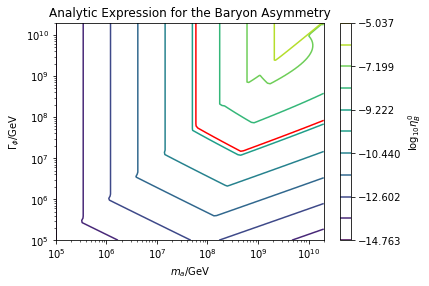

In [14]:
# make a plot of the final baryon asymmetry as a function of the axion mass and the inflaton
# decay rate and highlight the contourline with the observed asymmetry
steps = 100
f_a = 3e14
Gamma_phis = np.geomspace(1e5, H_inf_max, steps) # constraint
m_as = np.geomspace(1e5, H_inf_max, steps + 1) # constraint
eta_B_0 = np.array([[eta_L_a_to_eta_B_0(calc_eta_L_a_analytic(m_a, f_a, Gamma_phi)) 
            for m_a in m_as] for Gamma_phi in Gamma_phis])
log_eta = np.log10(eta_B_0)
levels = np.sort(np.concatenate([np.linspace(np.min(log_eta), np.max(log_eta), 10), [np.log10(eta_B_observed)]]))
CS = plt.contour(m_as, Gamma_phis, log_eta, levels=levels)
cbar = plt.colorbar()
cbar.set_label(r"$\log_{10} \eta_B^0$")
line = CS.collections[np.where(CS.levels == np.log10(eta_B_observed))[0][0]]
line.set_color("red")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.title("Analytic Expression for the Baryon Asymmetry")